<a href="https://colab.research.google.com/github/ffabi/AssettoCorsaSelfDriving/blob/master/AssettoCorsaSelfDriving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from sklearn import preprocessing
from keras.preprocessing.image import img_to_array, ImageDataGenerator
import random
from tensorflow import set_random_seed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, BatchNormalization
from keras.models import Sequential, load_model
from keras.optimizers import Adam, SGD
import PIL
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import sys

In [0]:
np.random.seed(1234)
set_random_seed(1234)

#Connect to google drive

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

#change working directory to google drive
import os
os.chdir("gdrive/My Drive/AssettoCorsaSelfDriving")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip original.zip

Archive:  original.zip
  inflating: Assetto Corsa 2019-01-06 14-58-01.mp4  


In [0]:
!mv *.mp4 videostream.mp4

In [4]:
!ls

frames	log.txt  original.zip  resized_frames  videostream.mp4	weights.hdf5


In [0]:
startframe = 153
endframe = 2284

In [0]:
cap = cv2.VideoCapture('videostream.mp4')

for i in range(startframe):
    cap.read()

In [0]:
framecounter=0

while framecounter < endframe - startframe:
    ret, frame = cap.read()
    cropped = frame[250:]
    cv2.imwrite("frames/frame_" + str(framecounter) + ".png", cropped)
    framecounter += 1

In [0]:
ret, frame = cap.read()

bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
fig=plt.figure(figsize=(18, 10))

plt.imshow(bgr[250:])
plt.axis('off')
plt.show()

In [0]:
framecounter=2131

In [0]:
!mkdir resized_frames

In [17]:
width = 200
for i in range(framecounter):
    img = Image.open("frames/frame_" + str(i) + ".png")
    wpercent = (width / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((width, hsize), PIL.Image.ANTIALIAS)
    img.save("resized_frames/frame_" + str(i) + ".png")
    
    cnt = int(i/framecounter*50)
    sys.stdout.write('\r'+ "Processing. [" + "="*cnt + ">" + " "*(50-cnt-1) + "]")

Processing. [=================================================>]

In [10]:
img = Image.open("resized_frames/frame_0.png")
img_shape = (img.size[1], img.size[0], 3)
img_shape

(73, 200, 3)

In [0]:
# dataset = np.zeros((framecounter, ), dtype=[('steer', np.float32), ('brake', np.float32), ("gas", np.float32), ("frame", np.int16)])
dataset = np.zeros(framecounter, dtype=[('data', np.float32, 3), ('frame', np.int16, 1)])

In [0]:
metafile = open("log.txt")

for i in range(framecounter):
    values = metafile.readline().split(";")
    
    steer = values[0]
    brake = values[1]
    gas = values[2]
    
    dataset[i]["data"] = (steer, brake, gas)
    dataset[i]["frame"] = i
    
    #the metafile contains an additional line
    metafile.readline()

metafile.close()

In [65]:
dataset

array([([-2.2473795,  0.       ,  1.       ],    0),
       ([-2.308914 ,  0.       ,  1.       ],    1),
       ([-2.7570264,  0.       ,  1.       ],    2), ...,
       ([-2.8505955,  0.       ,  1.       ], 2128),
       ([-2.8630824,  0.       ,  1.       ], 2129),
       ([-2.8000185,  0.       ,  1.       ], 2130)],
      dtype=[('data', '<f4', (3,)), ('frame', '<i2')])

In [0]:
np.random.shuffle(dataset)

In [69]:
dataset

array([([ 69.53593   ,   0.        ,   0.        ], 1522),
       ([ 25.392714  ,   0.35273403,   0.        ], 1390),
       ([  1.3139105 ,   0.        ,   1.        ], 2114), ...,
       ([ -0.07368842,   0.        ,   1.        ],    6),
       ([  0.74219906,   0.        ,   1.        ], 2078),
       ([-57.463825  ,   0.        ,   0.1460704 ], 1793)],
      dtype=[('data', '<f4', (3,)), ('frame', '<i2')])

In [70]:
valid_split = 0.2
test_split = 0.1

train = dataset[0:int(framecounter*(1-valid_split-test_split))]
valid = dataset[int(framecounter*(1-valid_split-test_split)):int(framecounter*(1-test_split))]
test  = dataset[int(framecounter*(1-test_split)):]

print(len(train))

1491


In [71]:
print(np.amin(train["data"][:, 0]), "-", np.amax(train["data"][:, 0]))
print(np.amin(train["data"][:, 1]), "-", np.amax(train["data"][:, 1]))
print(np.amin(train["data"][:, 2]), "-", np.amax(train["data"][:, 2]))


#standard scaler
scaler = preprocessing.MinMaxScaler().fit(train["data"])
train["data"] = scaler.transform(train["data"])
valid["data"] = scaler.transform(valid["data"])
test["data"] = scaler.transform(test["data"])

print(train)

print(np.amin(train["data"][:, 0]), "-", np.amax(train["data"][:, 0]))
print(np.amin(train["data"][:, 1]), "-", np.amax(train["data"][:, 1]))
print(np.amin(train["data"][:, 2]), "-", np.amax(train["data"][:, 2]))

-110.58277 - 130.18669
0.0 - 1.0
0.0 - 1.0
[([0.74809605, 0.        , 0.        ], 1522)
 ([0.56475383, 0.35273403, 0.        ], 1390)
 ([0.46474612, 0.        , 1.        ], 2114) ...
 ([0.60957605, 0.        , 0.12000575], 1656)
 ([0.53626   , 0.        , 0.2       ],  953)
 ([0.12841332, 0.04913072, 0.        ], 1774)]
0.0 - 0.9999999
0.0 - 1.0
0.0 - 1.0


In [0]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, dataset, dim, batch_size=10, shuffle=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
        

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        ids = [self.dataset["frame"][k] for k in indexes]
        datapoints = [self.dataset["data"][k] for k in indexes]

        """Generates data containing batch_size samples"""
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim), dtype=float)
        Y = np.empty((self.batch_size, *(3, )), dtype=float)
        # Generate data
        for i, ID in enumerate(ids):
            img = img_to_array(load_img('resized_frames/frame_' + str(ID) + '.png'))
            img = img / 255
            # Store sample
            X[i,] = img
            
            # Store data
            Y[i,] = datapoints[i]

        return X, Y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [0]:

class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    A = (K.sigmoid(x) * x)
    return A

get_custom_objects().update({'swish': Swish(swish)})

In [0]:
model = Sequential([
    Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='swish', input_shape=img_shape),
    Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='swish'),
    Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='swish'),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='swish'),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='swish'),
    Flatten(),
    Dense(100, activation='swish'),
    Dense(50, activation='swish'),
    Dense(10, activation='swish'),
    Dense(3)
])

In [77]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.8, nesterov=True)
model.compile(optimizer=sgd, loss="mse", metrics=['mae', 'acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 35, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 2, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               230500    
__________

In [78]:
training_generator = DataGenerator(train, dim=img_shape, batch_size=64)
validation_generator = DataGenerator(valid, dim=img_shape, batch_size=64)

#setup early stopping
es = EarlyStopping(patience=12, verbose=1, min_delta=0.003)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

# set parameters and start learning
history = model.fit_generator(
            generator=training_generator,
            validation_data=validation_generator,
            use_multiprocessing=False,
          epochs=120, # early stopping detects the end
          verbose=1, 
          shuffle=True,
          callbacks=[mcp, es]
         )

Epoch 1/120
23/23 [==============================] - 6s 241ms/step - loss: 0.2759 - mean_absolute_error: 0.3839 - acc: 0.5781 - val_loss: 0.2593 - val_mean_absolute_error: 0.3748 - val_acc: 0.5599

Epoch 00001: val_loss improved from inf to 0.25928, saving model to weights.hdf5
Epoch 2/120
23/23 [==============================] - 3s 125ms/step - loss: 0.2379 - mean_absolute_error: 0.3565 - acc: 0.5795 - val_loss: 0.2292 - val_mean_absolute_error: 0.3549 - val_acc: 0.5781

Epoch 00002: val_loss improved from 0.25928 to 0.22920, saving model to weights.hdf5
Epoch 3/120
23/23 [==============================] - 5s 214ms/step - loss: 0.2079 - mean_absolute_error: 0.3343 - acc: 0.5808 - val_loss: 0.2005 - val_mean_absolute_error: 0.3341 - val_acc: 0.5729

Epoch 00003: val_loss improved from 0.22920 to 0.20055, saving model to weights.hdf5
Epoch 4/120
23/23 [==============================] - 5s 212ms/step - loss: 0.1834 - mean_absolute_error: 0.3159 - acc: 0.5781 - val_loss: 0.1779 - val_mean

In [0]:
# load back best model (early stopping + model checkpoint)
model = load_model('weights.hdf5')

In [0]:
def plot_history(network_history):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    #accuracy-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

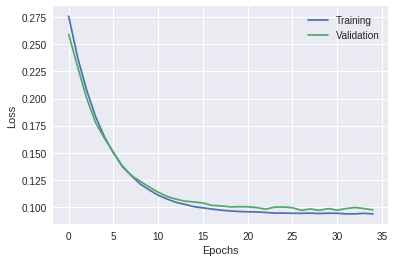

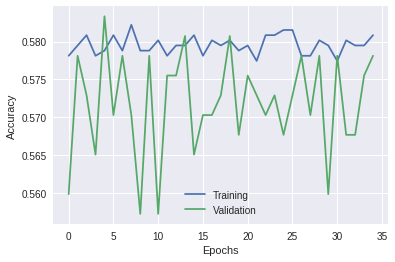

Test accuracy: 53.33%


In [81]:
#plot learning history
plot_history(history)

# Final evaluation of the model
test_generator = DataGenerator(test, dim=img_shape)
scores = model.evaluate_generator(test_generator, verbose=0)
print("Test accuracy: %.2f%%" % (scores[2]*100))

In [82]:
for i in range(100):
    img = np.array(cv2.imread("resized_frames/frame_" + str(i) + ".png", cv2.IMREAD_COLOR), copy=False, ndmin=4)
    print((model.predict(img)))

[[-1.1438667  1.6298748  2.7541268]]
[[-1.3141645  1.7255535  2.8651013]]
[[-0.98374796  1.5205691   2.5940344 ]]
[[-0.5475329  1.8445613  1.7031202]]
[[-0.6140429  1.4538352  1.945756 ]]
[[-0.8747307  1.216759   2.4866679]]
[[-1.0436379  1.2256286  2.2827382]]
[[-1.304793   1.380459   2.7353644]]
[[-1.9459591  1.1381702  4.134198 ]]
[[-1.8079288  0.8446934  4.038707 ]]
[[-1.5421687  1.1928134  3.4454405]]
[[-1.3679011  1.6477797  3.0583496]]
[[-1.374221   1.7425902  2.8179548]]
[[-0.8321893  1.9683298  1.7976987]]
[[-1.1798612  1.6249902  2.5676446]]
[[-1.7846184  1.1850178  4.266211 ]]
[[-0.8609868  1.8140606  2.4479437]]
[[-1.0873746   0.80078363  2.5976257 ]]
[[-0.04253    1.6197714  0.8590706]]
[[-0.32350937  2.0460882   1.0503331 ]]
[[-0.77368927  2.207308    2.024556  ]]
[[-1.3043231  0.9956486  3.31587  ]]
[[-1.2434801   0.55692524  3.3555777 ]]
[[-1.726855   0.7113714  4.5827622]]
[[-1.4107428  0.8650665  3.7428112]]
[[-1.4272691  1.0763875  3.652359 ]]
[[-0.7304785  1.7322292

In [133]:
img = np.array(cv2.imread('resized_frames/frame_50.png', cv2.IMREAD_COLOR), copy=False, ndmin=4)
print(img.shape)
print(model.predict(np.transpose(img, (1,0,2))))

(1, 73, 200, 3)


ValueError: ignored